In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../data/advertising.csv')
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


In [3]:
features = ['Daily Time Spent on Site',	'Age' ,'Area Income' ,'Daily Internet Usage']
target = 'Clicked on Ad'

X = df[features].values
y = df[target].values.reshape(-1)

X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_norm = (X - X_mean) / X_std

In [4]:
def train_test_split(X, y, test_ratio=0.2, seed=42):
    np.random.seed(seed)
    shuffled_indices = np.random.permutation(len(X))
    test_size = int(test_ratio*len(X))
    test_indices = shuffled_indices[:test_size]
    train_indices = shuffled_indices[test_size:]
    return X[train_indices] , X[test_indices] , y[train_indices] , y[test_indices]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y)

In [6]:
def sigmoid(z):
    return 1/(1+ np.exp(-z))

In [7]:
def compute_cost(X, y, w, b, lambda_ = 1):
    m,n = X.shape
    cost = 0
    for i in range(m):
        z_i = np.dot(X[i], w) + b
        f_wb_i = np.clip(sigmoid(z_i), 1e-15, 1 - 1e-15) 
        cost += -y[i]*np.log(f_wb_i) - (1-y[i])*np.log(1-f_wb_i)
    cost = cost/(m)
    
    reg_cost = 0
    for j in range(n):
        reg_cost += (w[j]**2)
    reg_cost = (lambda_/(2*m)) * reg_cost  
    
    total_cost = cost + reg_cost                                       
    return total_cost     

In [8]:
def compute_gradient(X, y, w, b, lambda_):
    m,n= X.shape
    
    dj_dw = np.zeros(n)
    dj_db = 0
    
    for i in range(m):
        z_i = np.dot(X[i], w) + b
        f_wb_i = np.clip(sigmoid(z_i), 1e-15, 1 - 1e-15)
        err_i  = f_wb_i  - y[i]
        for j in range(n):
            dj_dw[j] +=  err_i * X[i,j]
        dj_db += err_i
    dj_dw = dj_dw/m                                   
    dj_db = dj_db/m                                   

    for j in range(n):
        dj_dw[j] = dj_dw[j] + (lambda_/m) * w[j]

    return dj_db, dj_dw  

In [9]:
def gradient_descent(X, y, w_in, b_in, alpha, num_iters, lambda_):
    w = w_in.copy()
    b = b_in
    J_history = []
    for i in range(num_iters):
        dj_db , dj_dw = compute_gradient(X, y, w, b, lambda_)
        w = w - alpha*dj_dw
        b = b - alpha*dj_db

        if i%100 == 0:
            cost = compute_cost(X, y, w, b, lambda_ = 1)
            J_history.append(cost)
            print(f"Iteration {i:4d} : Cost {cost:.4f}")

    return w , b , J_history

In [10]:
w_init = np.zeros(X.shape[1])  # shape (n,)
b_init = 0
alpha = 0.01
iterations = 1000
lambda_ = 1

w_final, b_final, cost_history = gradient_descent(X_train , y_train, w_init, b_init, alpha, iterations, lambda_)


Iteration    0 : Cost 0.6889
Iteration  100 : Cost 0.4219
Iteration  200 : Cost 0.3104
Iteration  300 : Cost 0.2533
Iteration  400 : Cost 0.2192
Iteration  500 : Cost 0.1969
Iteration  600 : Cost 0.1811
Iteration  700 : Cost 0.1693
Iteration  800 : Cost 0.1603
Iteration  900 : Cost 0.1531


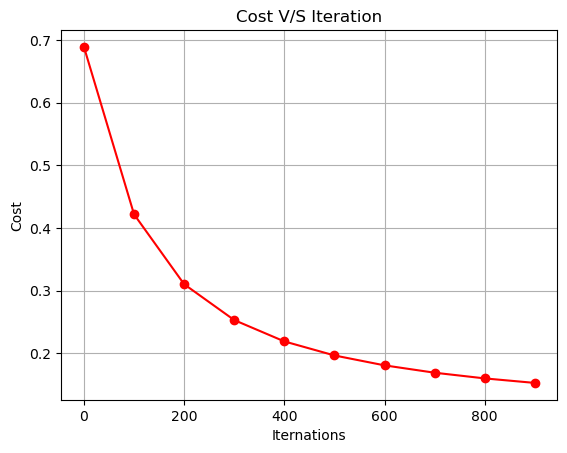

In [11]:
plt.plot(range(0, iterations , 100) , cost_history, marker='o' , c='r' )
plt.xlabel("Iternations")
plt.ylabel("Cost")
plt.title("Cost V/S Iteration")
plt.grid(True)
plt.show()

In [12]:
def predict(X, w, b):
    z = np.dot(X, w) + b
    probs = 1 / (1 + np.exp(-z))       # sigmoid
    return (probs >= 0.5).astype(int)  # threshold at 0.5


In [13]:
y_pred = predict(X_test, w_final, b_final)


In [14]:
def compute_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred) * 100

accuracy = compute_accuracy(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.2f}%")


Accuracy on test set: 94.00%


# Visualise Decision Boundary

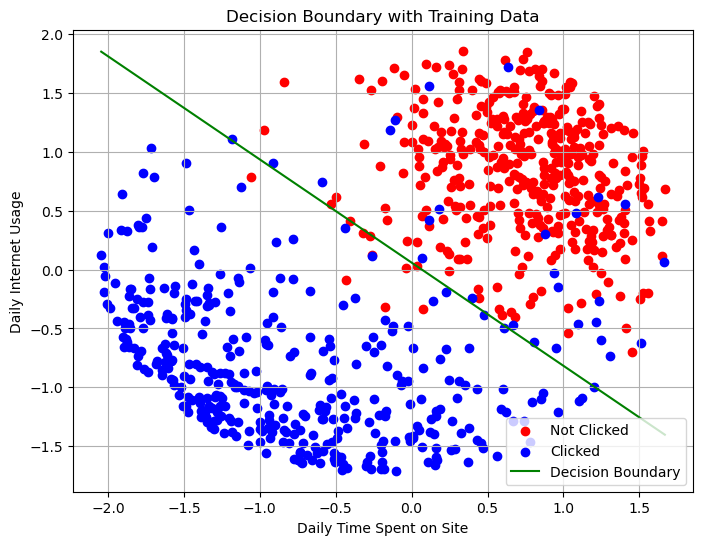

In [16]:
feature_idx = [0, 3]  # Choose first 2 features for plotting
X_plot = X_train[:, feature_idx]
w_plot = w_final[feature_idx]

# Plotting
plt.figure(figsize=(8,6))
plt.scatter(X_plot[y_train==0][:,0], X_plot[y_train==0][:,1], c='red', label='Not Clicked')
plt.scatter(X_plot[y_train==1][:,0], X_plot[y_train==1][:,1], c='blue', label='Clicked')

# Decision boundary: w1*x1 + w2*x2 + b = 0 --> x2 = -(b + w1*x1)/w2
x_values = np.linspace(X_plot[:, 0].min(), X_plot[:, 0].max(), 100)
y_values = -(b_final + w_plot[0]*x_values) / w_plot[1]
plt.plot(x_values, y_values, label="Decision Boundary", color="green")

plt.xlabel(features[feature_idx[0]])
plt.ylabel(features[feature_idx[1]])
plt.title("Decision Boundary with Training Data")
plt.legend()
plt.grid(True)
plt.show()
